In [202]:
# Data sourced from the St. Louis Fed (FRED) - https://fred.stlouisfed.org/series/RSXFS
# NOTE: data is on a monthly-basis and adjusted for seasonality

In [181]:
import pandas as pd
import datetime
import pandas.plotting as pd_plt
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Data Ingestion

In [132]:
file_path = 'retail_sales.csv'

df = pd.read_csv(file_path, names=['date', 'sales'], header=0)

df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)
df.index = df.index.to_period('M')

df.head()

,sales
date,
1992-01,146925
1992-02,147223
1992-03,146805
1992-04,148032
1992-05,149010


# Plot Time-Series Data

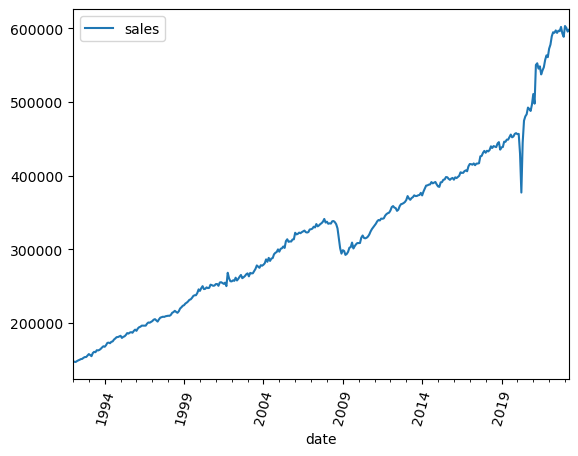

In [133]:
# plot monthly retail sales between 1993 and 2023
df.plot()
plt.xticks(rotation = 75)
plt.show()

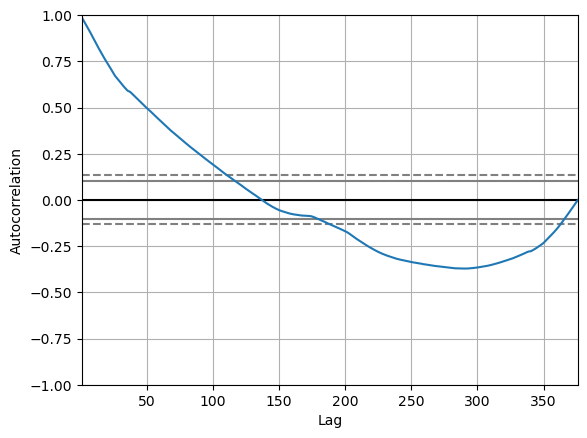

In [134]:
pd_plt.autocorrelation_plot(df)
plt.show()

# Split Data Into Decades

In [135]:
# split dataframe into dataframes by decade
df_1992_to_1999 = df.iloc[0:96, :]
df_2000_to_2009 = df.iloc[96:228, :]
df_2010_to_2022 = df.iloc[228:-4, :]
df_2023 = df.iloc[-4:, :]

df_2023.head(500)

,sales
date,
2023-01,603211
2023-02,600669
2023-03,595614
2023-04,597986


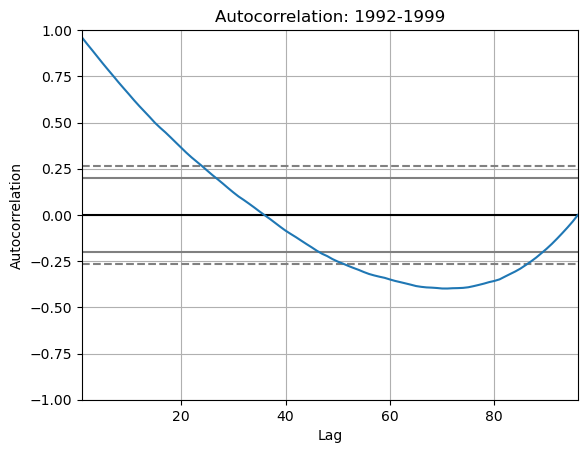

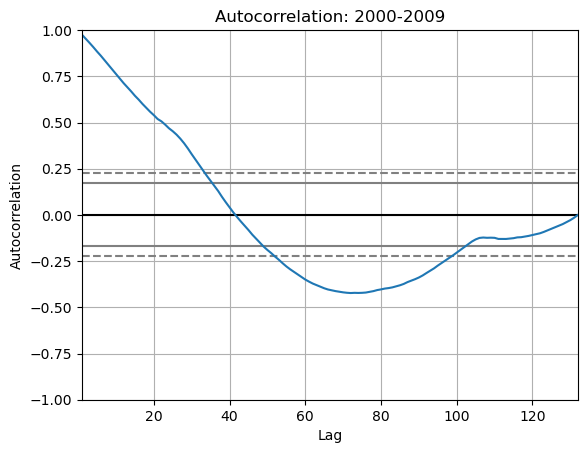

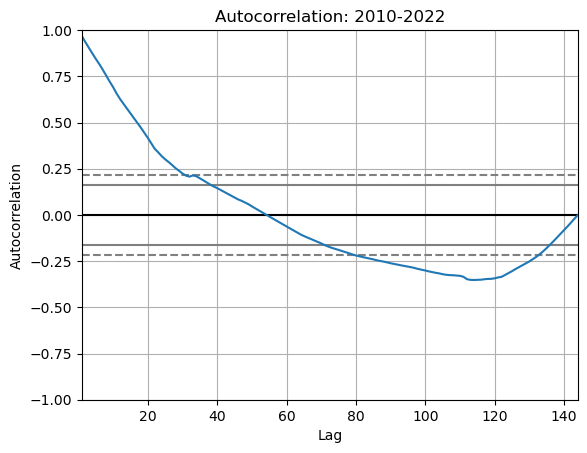

In [136]:
plt.figure('1992_1999')
plt.title("Autocorrelation: 1992-1999")
pd_plt.autocorrelation_plot(df_1992_to_1999)

plt.figure('2000_2009')
plt.title("Autocorrelation: 2000-2009")
pd_plt.autocorrelation_plot(df_2000_to_2009)

plt.figure('2010_2022')
plt.title("Autocorrelation: 2010-2022")
pd_plt.autocorrelation_plot(df_2010_to_2022)

plt.show()

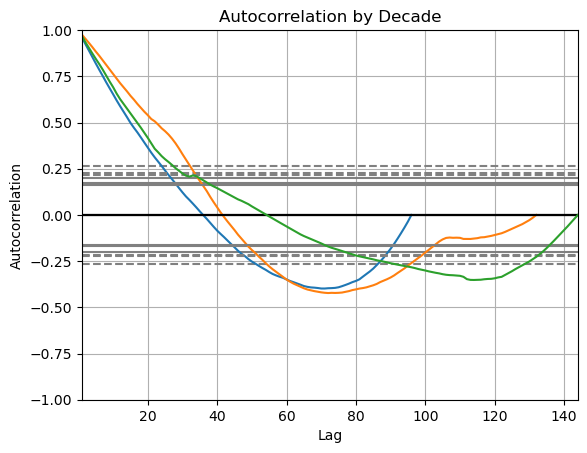

In [137]:
# overlay autocorrelation plots
plt.title("Autocorrelation by Decade")
pd_plt.autocorrelation_plot(df_1992_to_1999)

pd_plt.autocorrelation_plot(df_2000_to_2009)

pd_plt.autocorrelation_plot(df_2010_to_2022)

plt.show()

# Fit ARIMA Model

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                   96
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -843.555
Date:                Wed, 24 May 2023   AIC                           1699.110
Time:                        10:25:09   BIC                           1714.434
Sample:                    01-31-1992   HQIC                          1705.302
                         - 12-31-1999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0112      0.023      0.493      0.622      -0.033       0.056
ar.L2         -0.0017      0.052     -0.033      0.973      -0.104       0.100
ar.L3          0.0222      0.021      1.061      0.2

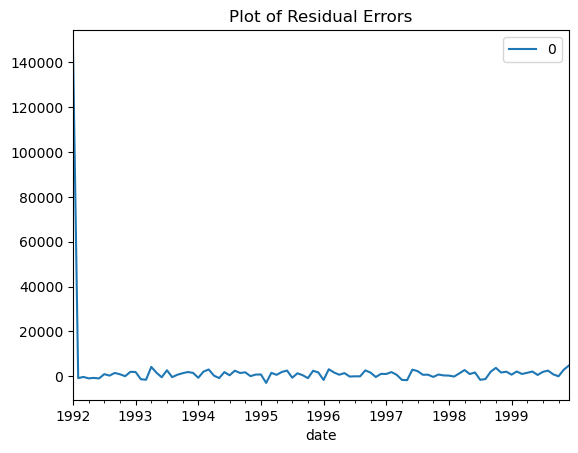

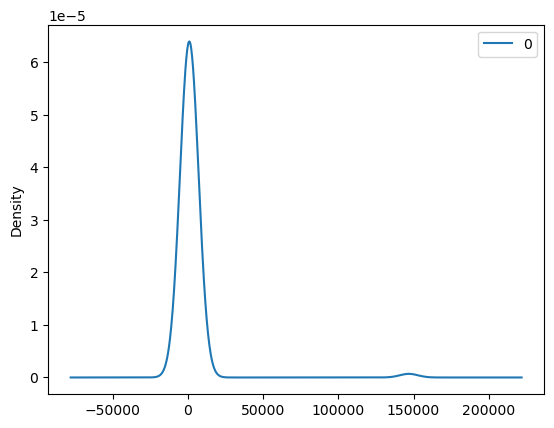

                   0
count      96.000000
mean     2424.138253
std     14970.542804
min     -2994.426567
25%       -47.046581
50%       947.401760
75%      1869.277828
max    146925.000000


In [174]:
# fit basic model using 1992 to 1999 data
# fit model
model = ARIMA(df_1992_to_1999, order=(5,1,0))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.title("Plot of Residual Errors")
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [183]:
# split 1992 to 1999 into training and testing set, testing set will simulate unseen values
sales_values = df_1992_to_1999.values
x_train, x_test = sales_values[:round(len(sales_values)*.7)], sales_values[round(len(sales_values)*.7):]

history = [x for x in x_train]
preds = list()

# walk forward validation
for t in range(len(x_test)):
    model = ARIMA(history, order=(20,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    preds.append(yhat)
    obs = x_test[t]
    history.append(obs)
    print(f'predicted=%f, expected=%f' % (yhat, obs))
    
rmse = sqrt(mean_squared_error(x_test, preds))
print('Test RMSE: %.3f' % rmse)

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


predicted=207386.608368, expected=207635.000000
predicted=207850.256073, expected=208326.000000
predicted=208437.177219, expected=208078.000000
predicted=208182.122856, expected=208936.000000
predicted=209158.549528, expected=209363.000000
predicted=209639.958031, expected=209666.000000
predicted=209777.616035, expected=209552.000000
predicted=209705.396158, expected=210832.000000
predicted=210927.248281, expected=213633.000000
predicted=213948.415630, expected=214639.000000
predicted=215029.791417, expected=216337.000000
predicted=216422.619814, expected=214841.000000
predicted=214792.850163, expected=213636.000000
predicted=213914.550564, expected=215720.000000
predicted=216019.167551, expected=219483.000000
predicted=219591.308744, expected=221134.000000
predicted=221389.301514, expected=223179.000000
predicted=223340.015507, expected=223997.000000
predicted=224205.087965, expected=226250.000000
predicted=226630.180347, expected=227417.000000
predicted=227590.059500, expected=229037

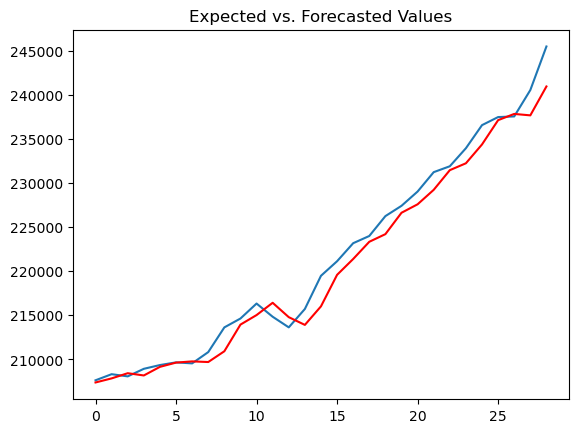

In [185]:
# plot actual vs. forecasted sales
plt.title("Expected vs. Forecasted Values")
plt.plot(x_test)
plt.plot(preds, color='red')
plt.show()

# Model Performance Over Time

In [200]:
# split all values into training and testing set
# SCENARIO: we have observed values from 1-1-1991 through 7-1-1997, today is 7-2-1997 and we are simulating 
# retraining a new model predicting on unseen data and then calculating RMSE at that point in time 
# (all observed vs. predicted values to the simulated date) on a monthly basis 

sales_values = df.values
x_train, x_test = sales_values[:67], sales_values[67:]

history = [x for x in x_train]
preds = list()

# walk forward validation
for t in range(len(x_test)):
    model = ARIMA(history, order=(20,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    preds.append(yhat)
    obs = x_test[t]
    history.append(obs)
    
rmse = sqrt(mean_squared_error(x_test, preds))
print('Test RMSE: %.3f' % rmse)

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test RMSE: 91658061.668


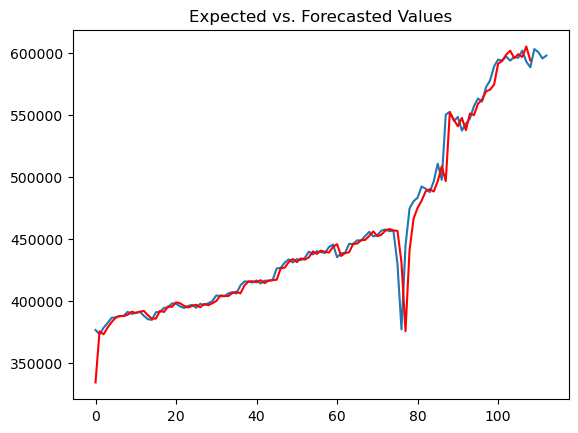

In [199]:
plt.title("Expected vs. Forecasted Values")
plt.plot(x_test)
plt.plot(preds, color='red')
plt.show()

In [204]:
# Prediction for May 2023 (FRED data has not been published at the time of execution)
model = ARIMA(history, order=(20,1,0))
model_fit = model.fit()
output = model_fit.forecast()
yhat = output[0]
print('Predicted May 2023 Sales: %.3f' % yhat)

Predicted May 2023 Sales: 599002.580
